<a href="https://www.kaggle.com/code/charunumesh/spaceship-titanic-xg-boost-cat-boost?scriptVersionId=126430131" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import catboost as cat
import category_encoders as ce
import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split,  StratifiedKFold, KFold,GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,confusion_matrix, log_loss

import warnings 
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# Import the training dataset

In [2]:
df_train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')


# Import the testing dataset

In [3]:
df_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [4]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
len(df_train)

8693

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
print(f"total train data : {len(df_train)}")
print(f"total test data : {len(df_test)}")

total train data : 8693
total test data : 4277


## checking the null values

In [8]:
df_train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [9]:
df_test.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

# Exploratory Data Analysis

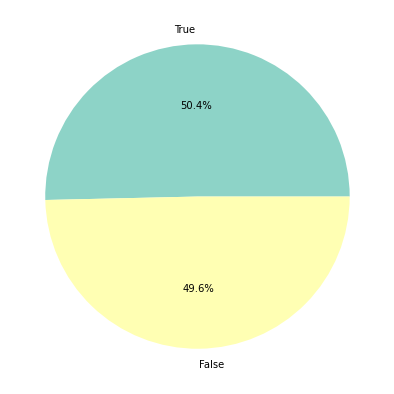

In [10]:
data = df_train['Transported'].value_counts()
labels = df_train['Transported'].value_counts().keys()

fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = labels, autopct="%1.1f%%", colors=sns.color_palette("Set3"))
 
# show plot
plt.show()

### Transported Feature Visualization

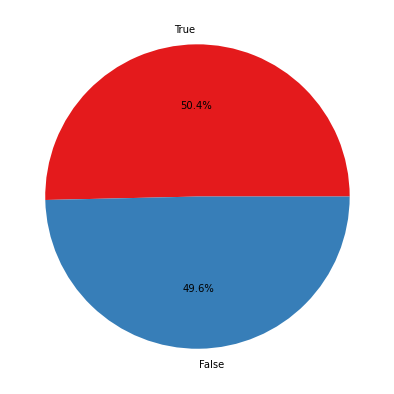

In [11]:
# Creating plot

data = df_train['Transported'].value_counts()
labels = df_train['Transported'].value_counts().keys()

fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = labels, autopct="%1.1f%%", colors=sns.color_palette("Set1"))
 
# show plot
plt.show()

### Visualizing the distribution of Age column

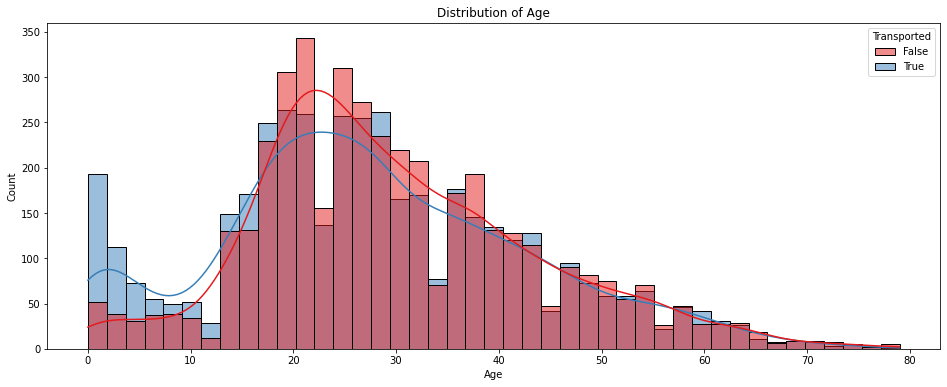

In [12]:
plt.figure(figsize=(16,6))
sns.histplot(x=df_train["Age"],hue="Transported",data=df_train,kde=True,palette="Set1")
plt.title("Distribution of Age");

### Distribution of Expenditure features

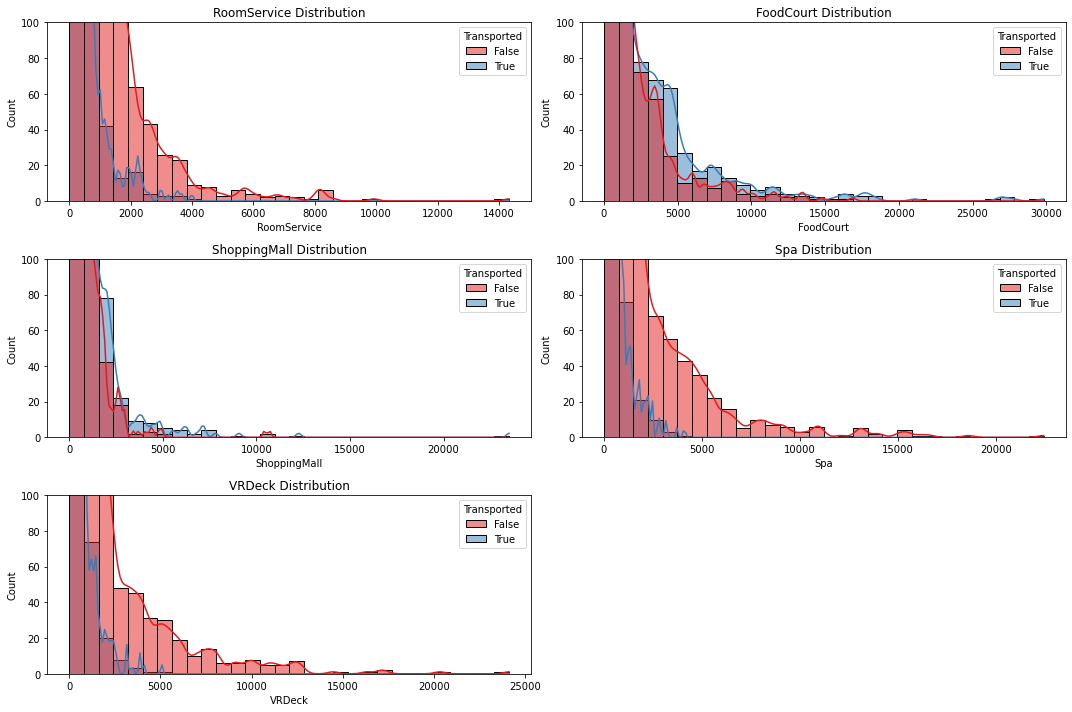

In [13]:
cols = ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]

plt.figure(figsize=(15,10))
for id,column in enumerate(cols):
    plt.subplot(3,2,id+1)
    sns.histplot(x=column, hue="Transported", data=df_train,bins=30,kde=True,palette="Set1")
    plt.title(f"{column} Distribution")
    plt.ylim(0,100)
    plt.tight_layout()

#### It seems that all these values are right skewed. we have to treat that when building the model

### Visualization of Categorical Features

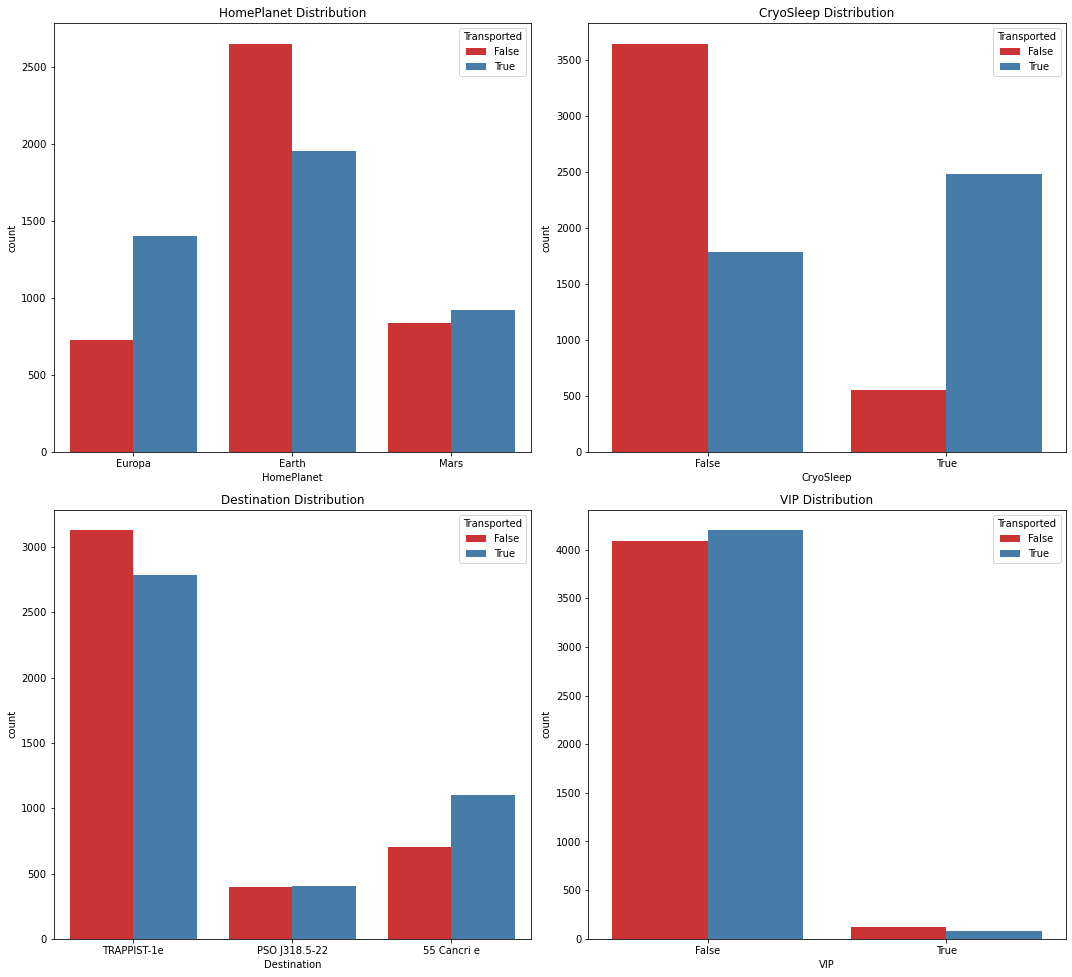

In [14]:
cat_cols = ["HomePlanet","CryoSleep","Destination","VIP"]

plt.figure(figsize=(15,20))
for id,column in enumerate(cat_cols):
    plt.subplot(3,2,id+1)
    sns.countplot(x=column, hue="Transported", data=df_train, palette="Set1")
    plt.title(f"{column} Distribution")

    plt.tight_layout()

#### In here, the VIP feature there's huge inbalance with the values. so it's better to remove this columns becuase it could cause our model to overfit

# Feature Engineering

In [15]:
df_train = df_train.drop(columns=[ 'PassengerId'], axis=1)


### Treat the null values

In [16]:
for i in df_train.columns:
    if df_train[i].dtypes == 'float64':
        df_train[i] = df_train[i].replace(np.NaN, df_train[i].mean())

In [17]:
for j in df_train.columns:
    if df_train[j].dtypes == 'object':
        mode_val = df_train[j].mode() 
        mode_1_val = df_train[j].value_counts().index.tolist()[1] 
        print(mode_val[0])
        df_train[j] = df_train[j].replace(np.NaN, mode_1_val)

Earth
False
G/734/S
TRAPPIST-1e
False
Alraium Disivering


In [18]:
df_train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


#### It seems that cabin feature value consist with 3 parts. deck, num and side. so lets seperate those 3 values and add as new features

In [19]:
cabin_cate = ['Deck', 'Number', 'Side']

for i in cabin_cate:
    df_train[i] = df_train['Cabin'].apply(lambda x: x.split("/")[cabin_cate.index(i)])

In [20]:
df_train["Number"]=df_train["Number"].astype(int)

#### Distribution of cabin num feature

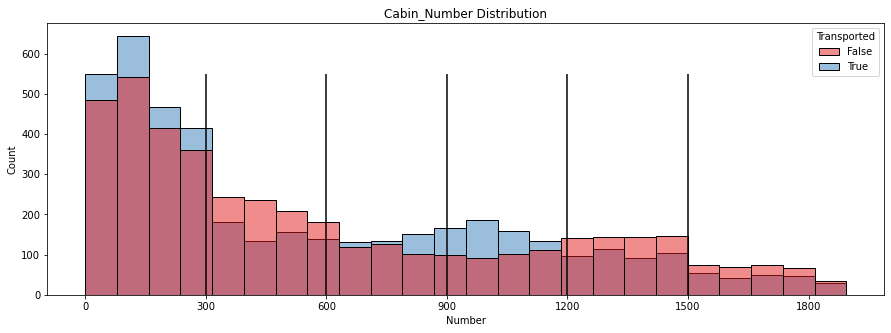

In [21]:
plt.figure(figsize=(15,5))
sns.histplot(x="Number",data=df_train,hue="Transported",palette="Set1")
plt.title("Cabin_Number Distribution")
plt.xticks(list(range(0,df_train['Number'].max(),300)))
plt.vlines(300,ymin=0,ymax=550,color="black")
plt.vlines(600,ymin=0,ymax=550,color="black")
plt.vlines(900,ymin=0,ymax=550,color="black")
plt.vlines(1200,ymin=0,ymax=550,color="black")
plt.vlines(1500,ymin=0,ymax=550,color="black")
plt.show()

#### We can divide the Number feature to several intervals

In [22]:
df_train['Number']

0          0
1          0
2          0
3          0
4          1
        ... 
8688      98
8689    1499
8690    1500
8691     608
8692     608
Name: Number, Length: 8693, dtype: int64

In [23]:
# # categorize the Age column in to several intervals. 
# df_train['Number_category'] = pd.cut(df_train['Number'], bins=[-1, 300, 600, 900, 1200, 1500, 2000], labels=range(1, 7))

# # Delete the Age column
# df_train = df_train.drop(columns='Number', axis=1)

In [24]:
df_train

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Number,Side
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,A,98,P
8689,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,G,1499,S
8690,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,G,1500,S
8691,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,E,608,S


In [25]:
# drop the name column

df_train = df_train.drop(columns=[ 'Cabin', 'VIP', 'Name'], axis=1)

In [26]:
df_train.head()

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Number,Side
0,Europa,False,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,303.0,70.0,151.0,565.0,2.0,True,F,1,S


In [27]:
df_train = pd.get_dummies(df_train, columns = ['HomePlanet','Destination', 'Deck', 'Side'])

In [28]:
df_train

,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Number,HomePlanet_Earth,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,False,39.0,0.0,0.0,0.0,0.0,0.0,False,0,0,...,0,1,0,0,0,0,0,0,1,0
1,False,24.0,109.0,9.0,25.0,549.0,44.0,True,0,1,...,0,0,0,0,0,1,0,0,0,1
2,False,58.0,43.0,3576.0,0.0,6715.0,49.0,False,0,0,...,1,0,0,0,0,0,0,0,0,1
3,False,33.0,0.0,1283.0,371.0,3329.0,193.0,False,0,0,...,1,0,0,0,0,0,0,0,0,1
4,False,16.0,303.0,70.0,151.0,565.0,2.0,True,1,1,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,False,41.0,0.0,6819.0,0.0,1643.0,74.0,False,98,0,...,1,0,0,0,0,0,0,0,1,0
8689,True,18.0,0.0,0.0,0.0,0.0,0.0,False,1499,1,...,0,0,0,0,0,0,1,0,0,1
8690,False,26.0,0.0,0.0,1872.0,1.0,0.0,True,1500,1,...,0,0,0,0,0,0,1,0,0,1
8691,False,32.0,0.0,1049.0,0.0,353.0,3235.0,False,608,0,...,0,0,0,0,1,0,0,0,0,1


####  Treat the Expenditure Features by applying the Log Transformation

In [29]:
cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck', 'Number']

for value in cols:
    df_train[value] = np.log(1+df_train[value])

#### Visualization of Expenditure features after the log transformation

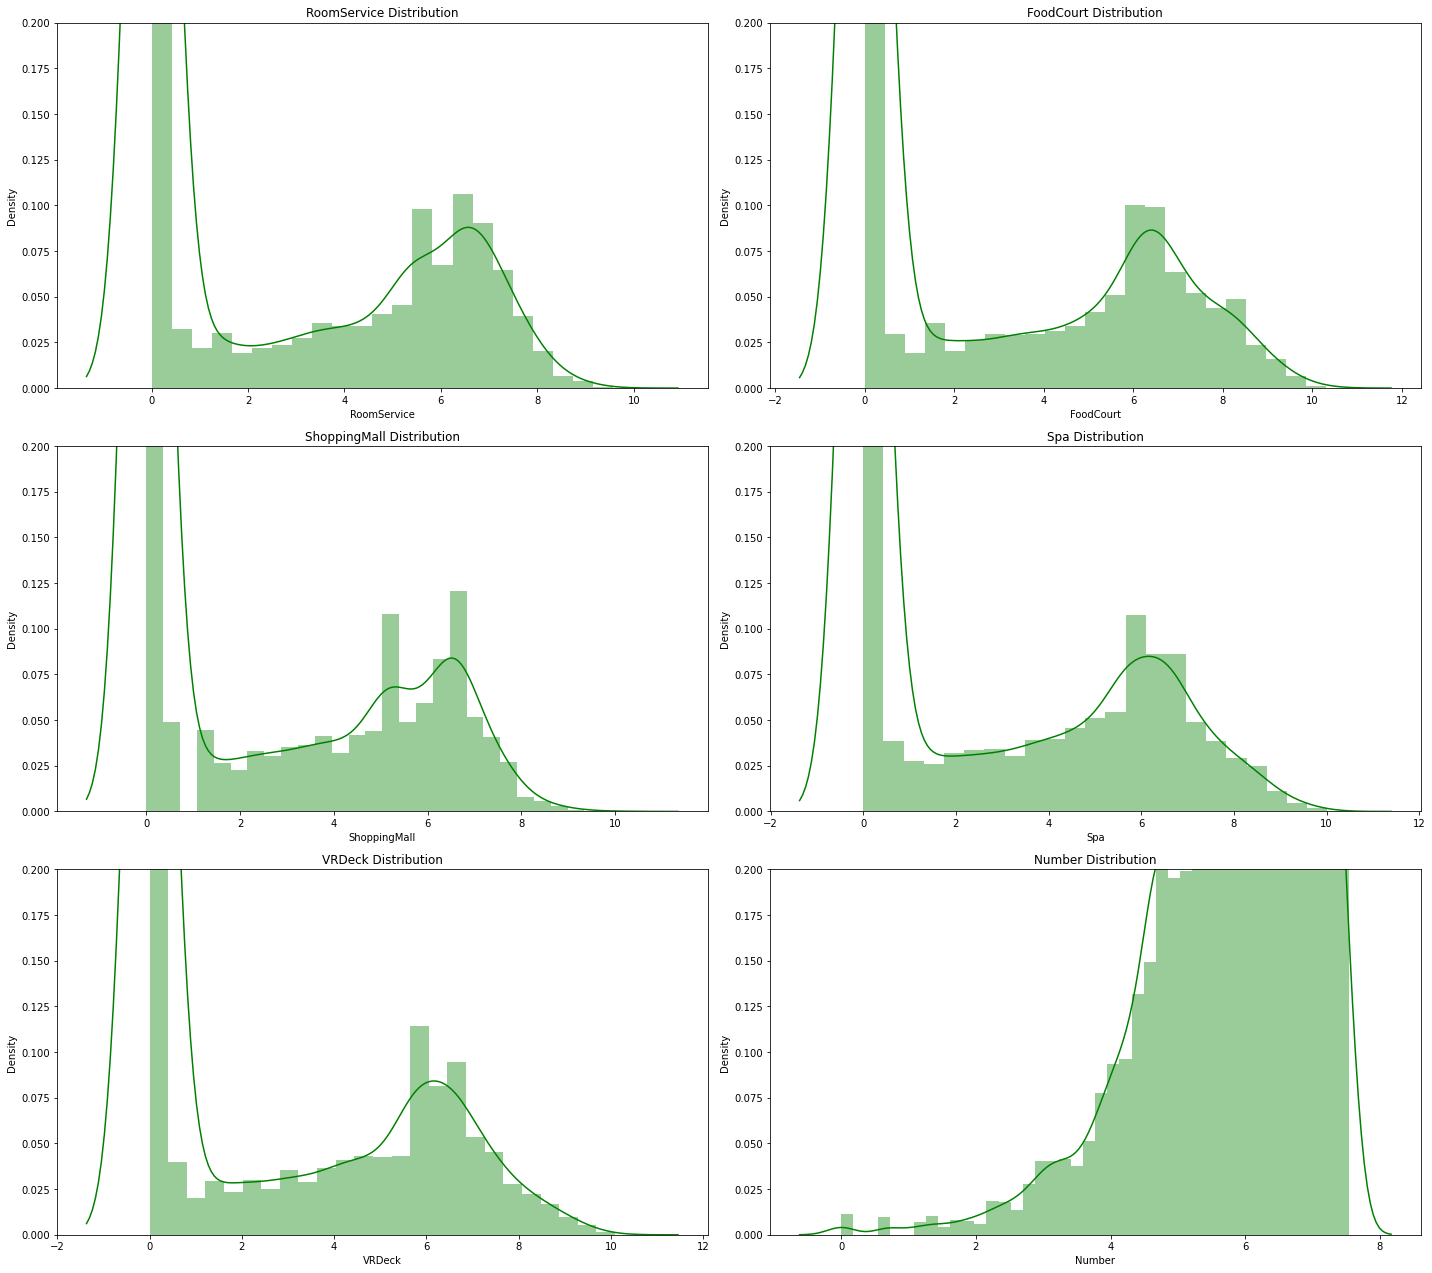

In [30]:
x=1

plt.figure(figsize=(20,35))
for i in cols:
    plt.subplot(6,2,x)
    sns.distplot(df_train[i],color="green")
    plt.ylim(0,0.2)
    plt.title(f"{i} Distribution")
    plt.tight_layout()
    x+=1

#### Encode features with boolean data type

In [31]:
bool_cols = [i for i in df_train.columns if df_train[i].dtypes == 'bool']

In [32]:
for i in bool_cols:
    #print(i)
    df_train[i] = df_train[i].replace({True: 1, False: 0})

In [33]:
df_train.head()


,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Number,HomePlanet_Earth,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0,39.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,...,0,1,0,0,0,0,0,0,1,0
1,0,24.0,4.700480,2.302585,3.258097,6.309918,3.806662,1,0.000000,1,...,0,0,0,0,0,1,0,0,0,1
2,0,58.0,3.784190,8.182280,0.000000,8.812248,3.912023,0,0.000000,0,...,1,0,0,0,0,0,0,0,0,1
3,0,33.0,0.000000,7.157735,5.918894,8.110728,5.267858,0,0.000000,0,...,1,0,0,0,0,0,0,0,0,1
4,0,16.0,5.717028,4.262680,5.023881,6.338594,1.098612,1,0.693147,1,...,0,0,0,0,0,1,0,0,0,1


# Test data

In [34]:
test_data = df_test.copy()

In [35]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [36]:
for i in test_data.columns:
    if test_data[i].dtypes == 'float64':
        test_data[i] = test_data[i].replace(np.NaN, test_data[i].mean())

In [37]:
for j in test_data.columns:
    if test_data[j].dtypes == 'object':
        mode_1_val = test_data[j].value_counts().index.tolist()[1]  
        print(mode_1_val)
        test_data[j] = test_data[j].replace(np.NaN, mode_1_val)

6288_02
Europa
True
D/273/S
55 Cancri e
True
Evendy Buchansen


In [38]:
cabin_cate_test = ['Deck', 'Number', 'Side']

for i in cabin_cate_test:
    test_data[i] = test_data['Cabin'].apply(lambda x: x.split("/")[cabin_cate_test.index(i)])
    
    
test_data["Number"]=test_data["Number"].astype(int)

In [39]:
test_data = test_data.drop(columns=['PassengerId', 'Name', 'Cabin', 'VIP'], axis=1)
test_data.head()

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Number,Side
0,Earth,True,TRAPPIST-1e,27.0,0.0,0.0,0.0,0.0,0.0,G,3,S
1,Earth,False,TRAPPIST-1e,19.0,0.0,9.0,0.0,2823.0,0.0,F,4,S
2,Europa,True,55 Cancri e,31.0,0.0,0.0,0.0,0.0,0.0,C,0,S
3,Europa,False,TRAPPIST-1e,38.0,0.0,6652.0,0.0,181.0,585.0,C,1,S
4,Earth,False,TRAPPIST-1e,20.0,10.0,0.0,635.0,0.0,0.0,F,5,S


In [40]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4277 non-null   object 
 1   CryoSleep     4277 non-null   bool   
 2   Destination   4277 non-null   object 
 3   Age           4277 non-null   float64
 4   RoomService   4277 non-null   float64
 5   FoodCourt     4277 non-null   float64
 6   ShoppingMall  4277 non-null   float64
 7   Spa           4277 non-null   float64
 8   VRDeck        4277 non-null   float64
 9   Deck          4277 non-null   object 
 10  Number        4277 non-null   int64  
 11  Side          4277 non-null   object 
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 371.9+ KB


In [41]:
test_data.isnull().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Deck            0
Number          0
Side            0
dtype: int64

In [42]:
test_data = pd.get_dummies(test_data, columns = ['HomePlanet','Destination', 'Deck', 'Side'])

In [43]:
cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

for value in cols:
    test_data[value] = np.log(1+test_data[value])

In [44]:
test_data.head()

,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Number,HomePlanet_Earth,HomePlanet_Europa,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,True,27.0,0.000000,0.000000,0.000000,0.000000,0.00000,3,1,0,...,0,0,0,0,0,0,1,0,0,1
1,False,19.0,0.000000,2.302585,0.000000,7.945910,0.00000,4,1,0,...,0,0,0,0,0,1,0,0,0,1
2,True,31.0,0.000000,0.000000,0.000000,0.000000,0.00000,0,0,1,...,0,0,1,0,0,0,0,0,0,1
3,False,38.0,0.000000,8.802823,0.000000,5.204007,6.37332,1,0,1,...,0,0,1,0,0,0,0,0,0,1
4,False,20.0,2.397895,0.000000,6.455199,0.000000,0.00000,5,1,0,...,0,0,0,0,0,1,0,0,0,1


In [45]:
bool_cols = [i for i in test_data.columns if test_data[i].dtypes == 'bool']
for i in bool_cols:
    #print(i)
    test_data[i] = test_data[i].replace({True: 1, False: 0})

In [46]:
X = df_train.drop(columns=['Transported'], axis=1)
y = df_train['Transported']

In [47]:
X.dtypes

CryoSleep                      int64
Age                          float64
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
Number                       float64
HomePlanet_Earth               uint8
HomePlanet_Europa              uint8
HomePlanet_Mars                uint8
Destination_55 Cancri e        uint8
Destination_PSO J318.5-22      uint8
Destination_TRAPPIST-1e        uint8
Deck_A                         uint8
Deck_B                         uint8
Deck_C                         uint8
Deck_D                         uint8
Deck_E                         uint8
Deck_F                         uint8
Deck_G                         uint8
Deck_T                         uint8
Side_P                         uint8
Side_S                         uint8
dtype: object

In [48]:
cat_params = {
             'colsample_bylevel': 0.9122807178002814,
             'iterations': 1000,
             'l2_leaf_reg': 0.8751327958077045,
             'learning_rate': 0.04519264945131604,
             'max_depth': 4,
             }

lgb_params = {
           'feature_fraction': 0.8332303620432719,
           'learning_rate': 0.06,
           'max_depth': 4,
           'n_estimators': 1000,
           'objective': 'binary',
           'random_state': 42,
           'reg_alpha': 0.84,
           'reg_lambda': 0.82,

}
     
xgb_params= {
         'colsample_bytree': 0.7,
         'learning_rate': 0.06,
         'max_depth': 4,
         'n_estimators': 900,
         'reg_alpha': 0.84,
         'reg_lambda': 0.82                        

}

In [49]:
df_train.dtypes

CryoSleep                      int64
Age                          float64
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
Transported                    int64
Number                       float64
HomePlanet_Earth               uint8
HomePlanet_Europa              uint8
HomePlanet_Mars                uint8
Destination_55 Cancri e        uint8
Destination_PSO J318.5-22      uint8
Destination_TRAPPIST-1e        uint8
Deck_A                         uint8
Deck_B                         uint8
Deck_C                         uint8
Deck_D                         uint8
Deck_E                         uint8
Deck_F                         uint8
Deck_G                         uint8
Deck_T                         uint8
Side_P                         uint8
Side_S                         uint8
dtype: object

In [50]:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
preds_xgb = np.zeros(test_data.shape[0])
preds_cat = np.zeros(test_data.shape[0])
preds_lgb = np.zeros(test_data.shape[0])
acc = []
acc_xgb = []
acc_cat = []
acc_lgb = []
n=0

for i, (train_index, valid_index) in enumerate(kfold.split(X,y)):
    x_train, y_train = X.iloc[train_index], y.iloc[train_index]
    x_valid, y_valid = X.loc[valid_index], y.iloc[valid_index]
    
    # XGBoost Classifer
    model_xgb = XGBClassifier(**xgb_params)
    model_xgb.fit(x_train,y_train,eval_set=[(x_valid,y_valid)],early_stopping_rounds=100,verbose=False) 
    preds_xgb+=model_xgb.predict_proba(test_data)[:, 1]/kfold.n_splits
    acc_xgb.append(accuracy_score(y_valid, model_xgb.predict(x_valid)))
    
    # Catboost Classifier
    model_cat = CatBoostClassifier(**cat_params)
    model_cat.fit(x_train,y_train,eval_set=[(x_valid,y_valid)],early_stopping_rounds=100,verbose=False) 
    preds_cat+=model_cat.predict_proba(test_data)[:, 1]/kfold.n_splits
    acc_cat.append(accuracy_score(y_valid, model_cat.predict(x_valid)))
    
    # LGBM Classifier
    model_lgb = LGBMClassifier(**lgb_params)
    model_lgb.fit(x_train,y_train,eval_set=[(x_valid,y_valid)],early_stopping_rounds=100,verbose=False)    
    preds_lgb+= model_lgb.predict_proba(test_data)[:, 1]/kfold.n_splits
    acc_lgb.append(accuracy_score(y_valid, model_lgb.predict(x_valid)))

    acc_val = (acc_xgb[n] + acc_cat[n] + acc_lgb[n]) / 3
    acc.append(acc_val)
    print(f"fold: {n+1} ==> acc: {acc_val}")
    n+=1

[LightGBM] [Warning] feature_fraction is set=0.8332303620432719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8332303620432719
fold: 1 ==> acc: 0.8164750957854405
[LightGBM] [Warning] feature_fraction is set=0.8332303620432719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8332303620432719
fold: 2 ==> acc: 0.8103448275862069
[LightGBM] [Warning] feature_fraction is set=0.8332303620432719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8332303620432719
fold: 3 ==> acc: 0.8164750957854405
[LightGBM] [Warning] feature_fraction is set=0.8332303620432719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8332303620432719
fold: 4 ==> acc: 0.8177982355197546
[LightGBM] [Warning] feature_fraction is set=0.8332303620432719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8332303620432719
fold: 5 ==> acc: 0.7882623705408515
[LightGBM] [Warning] feature_fraction is set=0.833

In [51]:
print(np.mean(acc))

0.8118400504389156


In [52]:
submission = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
submission['XGB'] = preds_xgb
submission['CAT'] = preds_cat
submission['LGB'] = preds_lgb

submission['Class_pred'] = ( submission['XGB'] * 0.33 + submission['CAT']* 0.34 + submission['LGB'] * 0.33 )
submission['Transported'] = np.where(submission['Class_pred']>=.50, 1, 0)

final_submission = pd.DataFrame(submission, columns=['PassengerId', 'Transported'])
final_submission['Transported'] = final_submission['Transported'].replace({1: True, 0: False})
final_submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


In [53]:
final_submission.to_csv('submission.csv', index=False)